# Questions
- [x] the text data file has 625 respondents; # data file has 583 -- need them to be downloaded at the same exact time to match

- [ ] the new data (see above) has responses "3" and "4" for the "Nationality" question, but there is no corresponding text to these responses anywhere in the data. let me know what they are and i can fix this easily. will just leave "3" and "4" for now

# Progress updates
    - 6/10 - cleaning up look of histograms/ finishing testing functionality, mapping text data
    - 6/16 - t-value calculations

# Notes
    - focus on getting histograms and t-tests for all the questions as they relate to the demographics so that we can get a sense of the data. Then get into linear regressions after that.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import math
from collections import OrderedDict
import re

In [2]:
matplotlib.rcParams['figure.figsize'] = [10, 8]

# Methods

In [3]:
## https://www.reddit.com/r/learnpython/comments/4i2z4u/how_to_add_a_new_line_after_every_nth_word/
def wrap_by_word(s, n):
    '''returns a string where \\n is inserted between every n words'''
    a = s.split()
    ret = ''
    for i in range(0, len(a), n):
        ret += ' '.join(a[i:i+n]) + '\n'

    return ret

In [4]:
#src: https://www.geeksforgeeks.org/counting-the-frequencies-in-a-list-using-dictionary-in-python/
def CountFrequency(my_list):
    # Creating an empty dictionary
    count = {}
    
    for i in my_list:
        count[i] = count.get(i, 0) + 1
    return count

In [5]:
def create_column_mapping(df, columns_text_list):
    ## returns: a dict with the keys = textual column labels
    ##     and values = raw data column labels 
    
    assert(type(df) == pd.core.frame.DataFrame)
    assert(type(columns_text_list) == list)
    
    raw_columns = pd.Index.tolist(df.columns)
    
    ## zip(keys, vals)
    return dict(zip(columns_text_list, raw_columns))
    
    

In [6]:
def create_question_answer_text_mapping(data, text_data, question_text):
    # 1 - go through each question. get all the potential responses
    # 2 - get their location in the dataframe
    # 3 - go into the text_data dataframe with that index 
    # 4 - map the raw data to the text data in a dictionary & return it
    
    # returns: a dict with the keys = raw column labels 
    #                          values = list[2] with [0] = textual column label + [1] a dict of the Q's answers,
    #                          with the keys = raw answers, values = textual answers
    
    assert(type(data) == pd.core.frame.DataFrame)
    assert(type(text_data) == pd.core.frame.DataFrame)
    
    tt = {k:[question_text[k], {}] for k in question_text.keys()}
    # get the unique vals for each Q
    ll = {col:[data.loc[:,col].unique()] for col in data.columns}
    ## not working randomly? kk = {k: {for i in a[0]} for q,a in ll.items()}
    kk = {}
    for q,a in ll.items():
        for i in a[0]:
            kk[q] = a[0]
            
    my_keys = list(ll.keys())[17:28]
    my_keys.extend(list(ll.keys())[28::5])
    my_keys.remove('I03')
    
    for q,a in ll.items():
        if q in my_keys:
            xx = tt[q][1]
            for i in a[0]:
                xx[i] = text_data[q][data[data[q]==i].index.values[0]]
                
    return tt

In [7]:
def clean_raw_data(df, elim_top_rows = 0, elim_every_other = False):
    ## returns: a dataframe containing only 
    ##      relevant rows from the raw data
    assert(type(df) == pd.core.frame.DataFrame)
    
    ## clean up extraneous top x rows
    data_temp = df.iloc[elim_top_rows:df.index.size]
    if elim_every_other == True:
        ## every other row in the raw data is blank. clean that up
        data_temp = data_temp.iloc[::2]
    return data_temp
    

In [8]:
def convert_data_types(df):
    ## df - dataframe
    ## NOTE: THIS OPERATES ON THE DATAFRAME IN PLACE
    for i in range(0,len(df.columns)):
        tempcol = df[df.columns[i]]
        testind = tempcol.index[0]
        
        try:
            float(tempcol[testind])
            df[df.columns[i]] = df[df.columns[i]].astype(float)
        except:
            #this doesnt seem to be working? (dont know if it matters) 
            df[df.columns[i]] = df[df.columns[i]].astype(str)    

In [9]:
def create_short_question_text(questions):
    
    short_questions = {}
    for k,v in questions.items():
        s = v.split()
        tmp = ""
        for t in s:
            if t.isupper() and len(t)>1:
                tmp = tmp + " " + t
            elif any(map(str.isdigit, t)):
                tmp = tmp + " " + t
                break
            else:
                break
        short_questions[k] = tmp
                
    
    return short_questions

In [10]:
def generate_x_axis_labels_hist(x_title, text_mapping, include_non_answers):
    
    data = dict(OrderedDict(sorted(text_mapping[x_title][1].items())))
    labels = []
    if float(0) in data.keys():
        data.pop(float(0))
    if include_non_answers == True:
        labels.append("No Response")
        
    s = " "
    for k,v in data.items():
        if len(str(v)) > 3: #4 is an arbitrary thresh, should work tho
            labels.append(v)
        else:
            s = s + " "
            labels.append(s)
    
    for i in range(0,len(labels)):
        labels[i] = wrap_by_word(labels[i], 3)
        if len(labels[i]) < 1:
            labels[i] = str(i+1)
            
    return labels
        

In [11]:
# this version of the histogram is for continuous data only (i.e. age)
# NEED TO FINISH 
def create_histogram_continuous(data, x_title, mapping, numbins=10, prob=True, include_non_answers=False, show_mean=False, 
                     show_resp_row_num=-1):
    
    t = mapping[x_title]
                          
    ## get the x data column from the dataframe
    data_col = pd.DataFrame(data, columns=[t])
    
    flat_list = [item for sublist in pd.Index.tolist(data_col) for item in sublist]
        
    ## THIS IS THE DIFFERENCE IN THIS METHOD 
    res = stats.binned_statistic(flat_list, flat_list, statistic='count', bins=numbins)
    counts = res[0]
    labels = res[1]
    
    # in the main code we replaced the NaNs with 0's, 
    # so here, we just eliminate that info from our hist before making graph
    if include_non_answers == False:
        labels = labels[1:len(labels)]
        counts = counts[1:len(counts)]
        
    fig, ax = plt.subplots()
    
    if prob == True:
        total = np.sum(counts)
        counts = [float(i) for i in counts]
        counts[:] = [x / total for x in counts]
        ax.set_ylabel("Probability")
    else:
        ax.set_ylabel("Frequency")
    
    # make range labels
    rangelabels = []
    for i in range(1, len(labels)):
        rangelabels.append("{:.1f}".format(labels[i-1])+" - "+"{:.1f}".format(labels[i]))
        
    ax.bar(rangelabels, counts, align='center')
    fig.gca().set_xticks(rangelabels)
    ax.set_xlabel(x_title)
    plt.xticks(rotation=45)
    
    # NEED TO FIX THIS FUNCTIONALITY FOR THIS
    if show_mean == True:
        mean = np.mean(flat_list)
        #ax.axvline(mean, color='k', linestyle='dashed', linewidth=1)
        #min_ylim, max_ylim = plt.ylim()
        ax.text(mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(mean))
    if show_resp_row_num > -1 and show_resp_row_num < len(flat_list)-1:
        resp = flat_list[show_resp_row_num]
        #ax.axvline(resp, color='k', linestyle='solid', linewidth=1)
        #min_ylim, max_ylim = plt.ylim()
        ax.text(resp*1.1, max_ylim*0.9, 'User {:}: {:}'.format(show_resp_row_num, resp))
    
    plt.show()

In [44]:
def create_histogram(data, x_title, mapping, text_mapping, prob=True, include_non_answers=False, show_mean=False, 
                     show_resp_row_num=-1, cont=False, numbins=10, show_full_title=True, short_titles=""):
    ## data -- clean data dataframe 
    ## x_title -- string
    ## include_non_answers -- boolean; includes people that didnt respond to the Q in the hist
    ## prob -- boolean; if true, show %'s, if false, show frequency
    ## mapping -- the column mapping returned from create_column_mapping
    ## show_mean -- boolean, shows the average from the histogram
    ## show_resp_row_num -- integer [0-# responses-1], the row number of the respondent whose answer you want to display
    
    t, question_text, flat_list, labels, counts, y_pos, data_col = hist_bar_setup(data, x_title, mapping, 
                                                                        text_mapping, include_non_answers=include_non_answers)
    
    # we need to manually bin and label the ranges for the continuous data, like age
    if cont==True:
        res = stats.binned_statistic(flat_list, flat_list, statistic='count', bins=numbins)
        counts = res[0]
        labels = res[1]
        # make range labels
        y_pos = list(range(0,len(counts)+1))
        x_axis_labels = []
        for i in range(1, len(labels)):
            x_axis_labels.append("{:.1f}".format(labels[i-1])+" - "+"{:.1f}".format(labels[i]))
    else:
        x_axis_labels = generate_x_axis_labels_hist(t, text_mapping, include_non_answers)
        
    fig, ax = plt.subplots()
    
    if include_non_answers == False:
        y_pos = y_pos[1:len(y_pos)+1]
    
    if prob == True:
        total = np.sum(counts)
        counts = [float(i) for i in counts]
        counts[:] = [x / total for x in counts]
        ax.set_ylabel("Probability")
    else:
        ax.set_ylabel("Frequency")
    

    ax.bar(y_pos, counts, align='center')
    #fig.gca().set_xticks(y_pos,x_axis_labels)
    plt.xticks(y_pos,x_axis_labels,rotation=90)
    
    if show_full_title == True:
        plt.title(question_text)
    else:
        plt.title(short_question_text[t])
        
    ax.set_xlabel('Responses')
    
    if show_mean == True:
        if include_non_answers == False:
            mean = np.mean(flat_list)
        else:
            temp = list(filter((0.0).__ne__, flat_list))
            temp = list(filter((0).__ne__, flat_list))
            mean = np.mean(flat_list)    
        ax.axvline(mean, color='k', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        ax.text(mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(mean))
    if show_resp_row_num > -1 and show_resp_row_num < len(flat_list)-1:
        resp = flat_list[show_resp_row_num]
        ax.axvline(resp, color='k', linestyle='solid', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        ax.text(resp*1.1, max_ylim*0.9, 'User {:}: {:}'.format(show_resp_row_num, resp))
        
    fn="../graphs/"+x_title+"_hist.png"
    plt.savefig(fn, bbox_inches='tight')
    plt.show()

In [15]:
def hist_bar_setup(data, x_title, mapping, text_mapping, include_non_answers=False):    
    
    t = mapping[x_title]
    ## get the x data column from the dataframe
    data_col = pd.DataFrame(data, columns=[t])
    question_text = wrap_by_word(text_mapping[t][0], 9)
    # insert linebreaks in titles, every 9 words (can change to whatever)
    
    flat_list = [item for sublist in pd.Index.tolist(data_col) for item in sublist]
    
    labels, counts = np.unique(flat_list, return_counts=True)
    
    # in the main code we replaced the NaNs with 0's, 
    # so here, we just eliminate that info from our hist before making graph
    if include_non_answers == False:
        labels = labels[1:len(labels)]
        counts = counts[1:len(counts)]

    y_pos = list(range(0,len(labels)+1))
        
    return t, question_text, flat_list, labels, counts, y_pos, data_col

In [46]:
def create_multi_histogram(data, x_title, mult_bar_title, mapping, text_mapping, prob=True, include_non_answers=False, 
                           show_mean=False, show_full_title=False, short_titles=""):
    ## data -- clean data dataframe 
    ## x_title -- string for x title 
    ## mult_bar_title -- string for the demo we want multiple bars comparing responses to x_title on
    ## include_non_answers -- boolean; includes people that didnt respond to the Q in the hist
    ## prob -- boolean; if true, show %'s, if false, show frequency
    ## mapping -- the column mapping returned from create_column_mapping
    ## show_mean -- boolean, shows the average from the histogram
    
    # get the number of unique answers for the demo we want to compare == # of bars we want in the graph
    # NOTE: include non-answers MUST be FALSE for demos
    width = 0.35
    
    t_demo, question_text_demo, flat_list_demo, labels_demo, counts_demo, y_pos_demo, data_col_demo = hist_bar_setup(data, 
                                                                                                                     x_title, 
                                                                                                                     column_mapping, text_mapping, 
                                                                                                                     include_non_answers=False)

    t, question_text, flat_list, labels, counts, y_pos, data_col = hist_bar_setup(data, mult_bar_title, column_mapping, text_mapping, 
                                                                                  include_non_answers=True)
            
    # for each demo, get the counts for each category in x_title and then make their bars
    num_bars = len(labels_demo)
    fig, ax = plt.subplots()
    all_counts = {}
    rects = {}

    grouped = data.groupby([mult_bar_title, x_title])['I03'].count() #we need to group by another column, idk why? (hence the I03 hardcoded here...)

    # get rid of 0 position 
    y_pos = y_pos[1:len(y_pos)-1]
    for i in range(0,num_bars):
        all_counts[labels_demo[i]] = []
        for j in range(0, len(labels)):
            all_counts[labels_demo[i]].append(grouped[j][labels_demo[i]])
        #this is to eliminate non answers from the counts
        all_counts[labels_demo[i]] = all_counts[labels_demo[i]][1:len(all_counts[labels_demo[i]])]

        if prob == True:
            tmp = sum(all_counts[labels_demo[i]])
            all_counts[labels_demo[i]] = [x/float(tmp) for x in all_counts[labels_demo[i]]]
        
        rects[labels_demo[i]] = ax.bar([x - (width/num_bars)*(2*i) for x in y_pos], all_counts[labels_demo[i]], 
                                   width, label=text_mapping[t_demo][1][labels_demo[i]])

    plt.legend(loc='best')
    #print(all_counts)
    #print(sum(all_counts[labels_demo[1]]))
    if prob == True:
        ax.set_ylabel("Probability")
    else:
        ax.set_ylabel("Frequency")
        
    x_axis_labels = generate_x_axis_labels_hist(t, text_mapping, include_non_answers)
    plt.xticks([x - width / num_bars for x in y_pos], x_axis_labels,rotation=90)


    for i in range(0,len(x_axis_labels)):
        x_axis_labels[i] = wrap_by_word(x_axis_labels[i], 3)
        if len(x_axis_labels[i]) < 1:
            x_axis_labels[i] = str(i+1)
  

    
    if show_full_title == True:
        plt.title(question_text)
    else:
        plt.title(short_question_text[t])
        
    ax.set_xlabel('Responses')
    
    # NEED TO ALTER THIS FOR THIS FUNCTION
    if show_mean == True:
        if include_non_answers == False:
            mean = np.mean(flat_list)
        else:
            temp = list(filter((0.0).__ne__, flat_list))
            temp = list(filter((0).__ne__, flat_list))
            mean = np.mean(flat_list)    
        ax.axvline(mean, color='k', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        ax.text(mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(mean))

    fn="../graphs/"+x_title+"_"+mult_bar_title+"_hist.png"
    plt.savefig(fn, bbox_inches='tight')
    plt.show()
    return all_counts
        

In [21]:
def calculate_t_test(data, mapping, a_name, b_name, equal_var=False, nan_policy='omit'):
    ## see scipy.stats.ttest_ind
    
    t_a = mapping[a_name]
    t_b = mapping[b_name]
    ## get the data columns from the dataframe
    data_col_a = pd.DataFrame(data, columns=[t_a])
    data_col_b = pd.DataFrame(data, columns=[t_b])
    
    flat_list_a = [item for sublist in pd.Index.tolist(data_col_a) for item in sublist]
    flat_list_b = [item for sublist in pd.Index.tolist(data_col_b) for item in sublist]
    
    return stats.ttest_ind(flat_list_a, flat_list_b, equal_var=equal_var, nan_policy=nan_policy)

# Main Code

### Settings

In [22]:
## show more items when printing for debugging purposes
pd.options.display.max_seq_items = 2000
pd.options.display.max_columns = 2000

### Read in and clean the data

In [23]:
## raw_data is of type(pandas.core.frame.DataFrame) -- 
## "DataFrame is a 2-dimensional labeled data structure 
## with columns of potentially different types. 
## You can think of it like a spreadsheet or SQL table, or a dict of Series objects."

## import the data file
raw_data = pd.read_csv('../Ethics_June+24,+2020_03.36 (1).csv')

## import the raw corresponding text answers
raw_text_data = pd.read_csv('../Ethics_June+24,+2020_03.36.csv')

In [24]:
# clean the # data and text data
data = clean_raw_data(raw_data, 5, True)
text_data = clean_raw_data(raw_text_data, 2, False)

In [25]:
# change the data types to floats (where applicable)
convert_data_types(data)

In [26]:
# replace the NaNs with 0's -- doing this for easier analyzations. this can be applied
# selectively to certain columns if we run into problems bc of this change
data.replace({np.NaN : 0}, inplace=True)

### Make some mappings between text descriptors and data for easier readability

In [27]:
# store the question text dict
question_text = raw_text_data.iloc[0, :].to_dict()
fix_trailing_ones = ['Q04_1','Q07_1', 'Q08_1', 'Q12_1', 'Q14_1', 'Q15_1']
for t in fix_trailing_ones:
    question_text[t] = question_text[t][0:len(question_text[t])-3]

In [28]:
short_question_text = create_short_question_text(question_text)

In [29]:
# create the mapping between textual column names and non-descriptive column names
# as is this is line is not doing anything, we can pass a list of titles as the last arg
# however, which will name the columns whatever you want to name them.
column_mapping = create_column_mapping(data,pd.Index.tolist(data.columns))

In [30]:
# hard coding this part for the column mapping
#column_mapping['Gender'] = column_mapping.pop('I02')
#column_mapping['Age'] = column_mapping.pop('I03')
#column_mapping['Race-Ethnicity'] = column_mapping.pop('I04')
#column_mapping['Education'] = column_mapping.pop('I05')
#column_mapping['Nationality'] = column_mapping.pop('I06')
#column_mapping['Income'] = column_mapping.pop('I07')

In [31]:
text_mapping = create_question_answer_text_mapping(data, text_data, question_text)

## Example of how to use the histogram function!

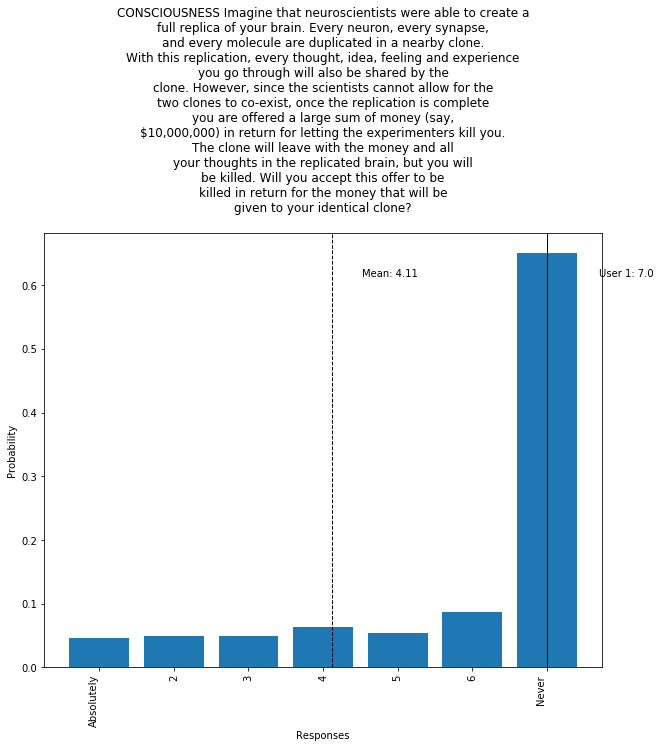

In [32]:
# this function is for categorical histogram data
create_histogram(data, 'Q07_1', column_mapping, text_mapping, prob=True, include_non_answers=False, 
                show_mean=True, show_resp_row_num=1)

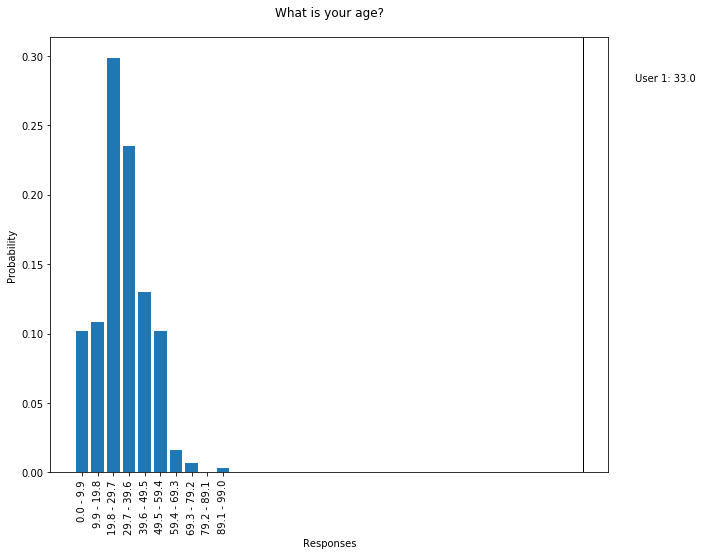

In [33]:
# this is the continuous histogram function -- it manually bins continuous data
# this function is for categorical histogram data
create_histogram(data, 'I03', column_mapping, text_mapping, prob=True, include_non_answers=False, 
                show_mean=False, show_resp_row_num=1, cont=True)

### Example of how to use t value calculation function

In [34]:
res = calculate_t_test(data, column_mapping, 'I02', 'Q01_1')
print(res)

Ttest_indResult(statistic=-8.913273879644763, pvalue=2.5838160832314346e-17)


## Make all of the single bar histograms

In [35]:
my_keys = list(column_mapping.keys())[17:23]
my_keys.extend(list(column_mapping.keys())[28::5])
my_keys = my_keys[0:len(my_keys)-1]

In [36]:
disp_means = [True] * 22
disp_means[0] = False; disp_means[0] = False; disp_means[1] = False; disp_means[2] = False; disp_means[3] = False; disp_means[4] = False
disp_means = dict(zip(my_keys, disp_means))


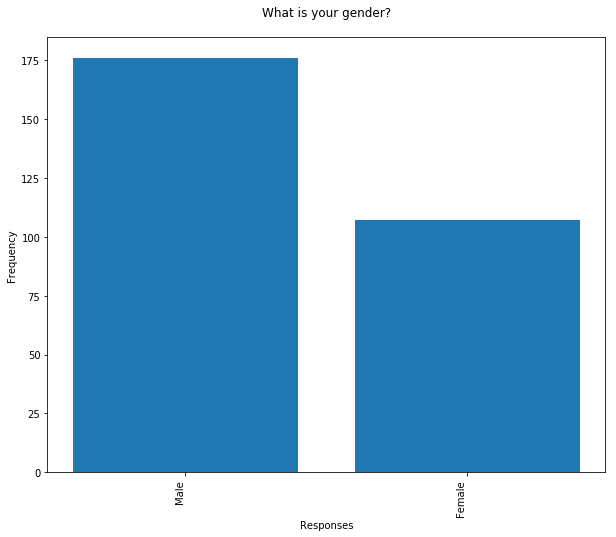

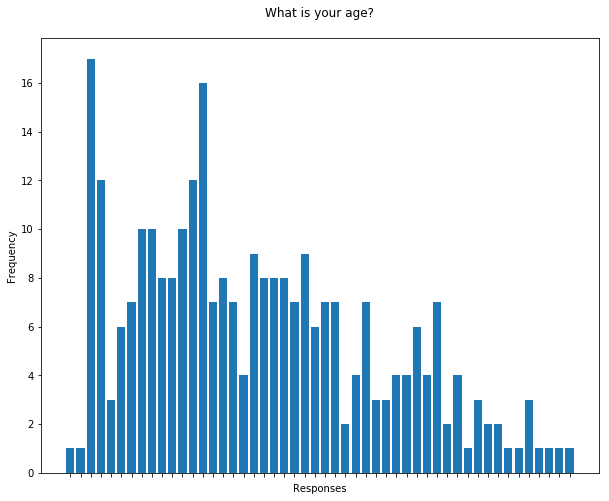

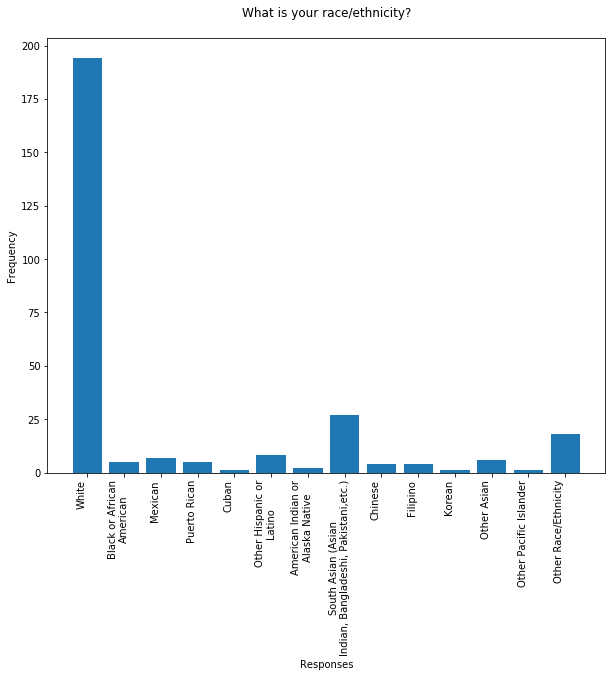

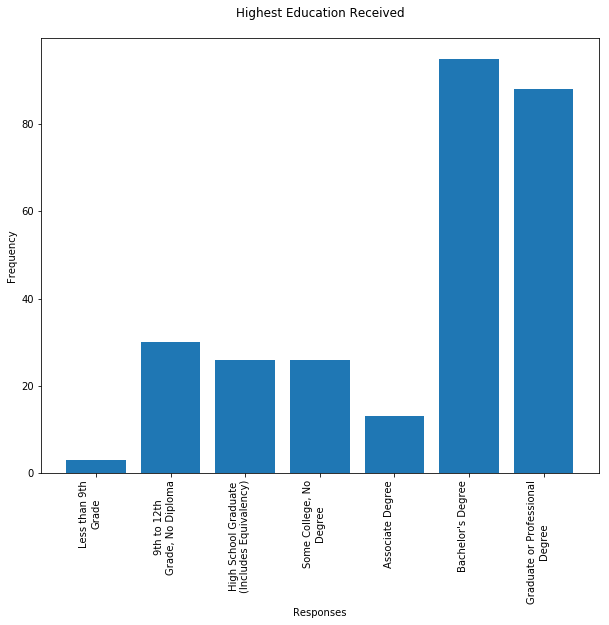

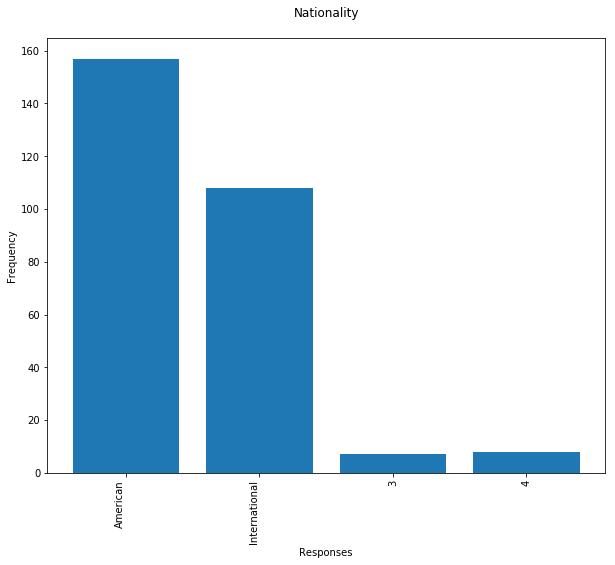

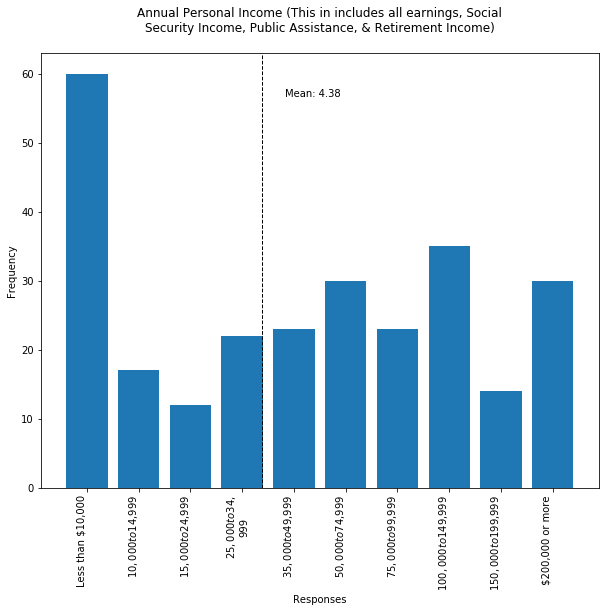

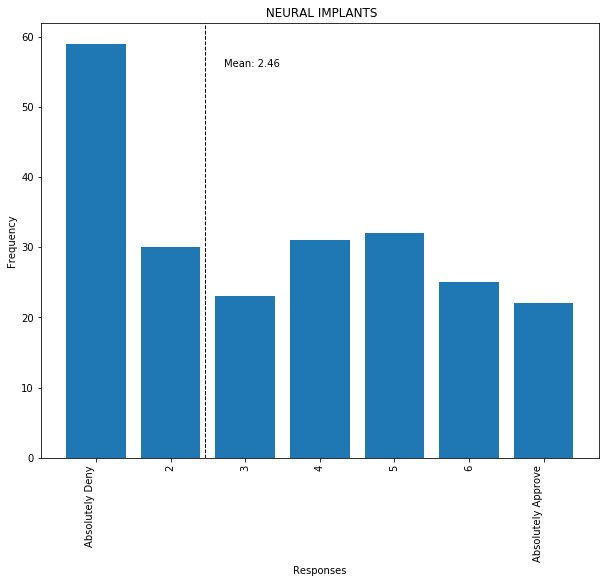

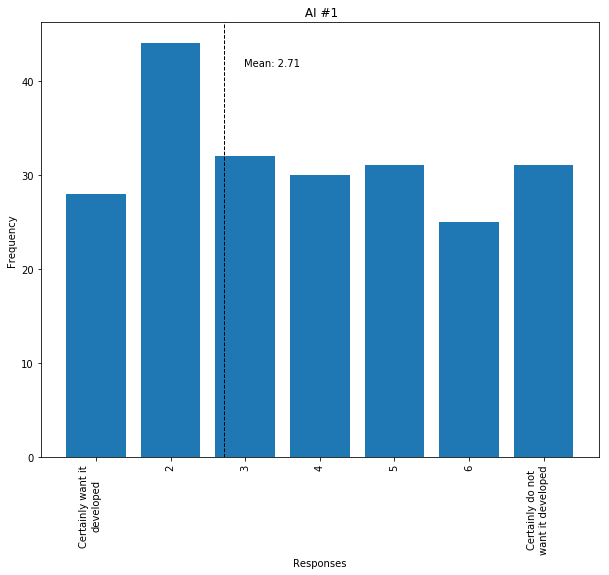

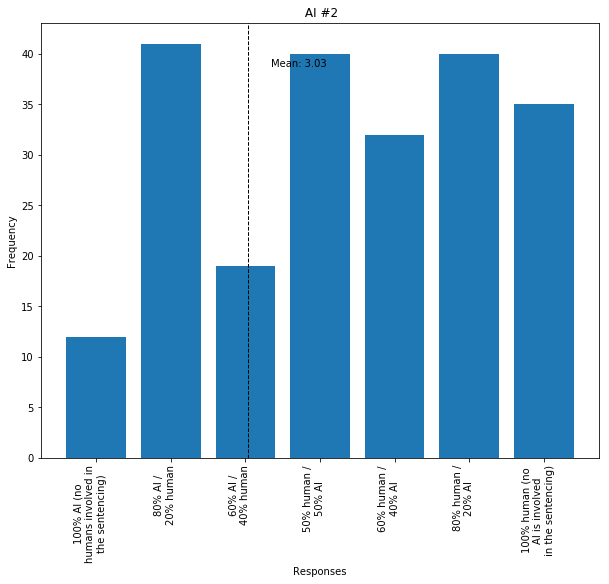

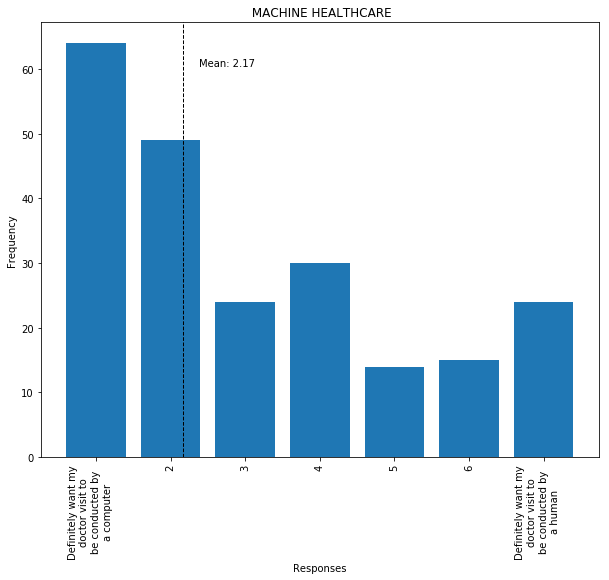

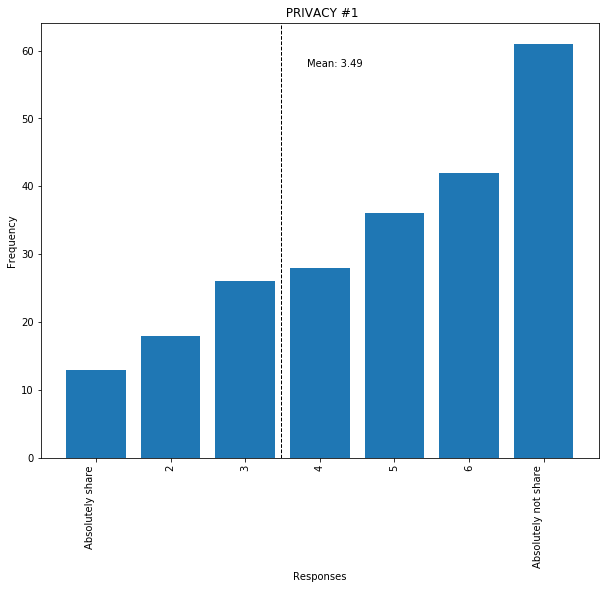

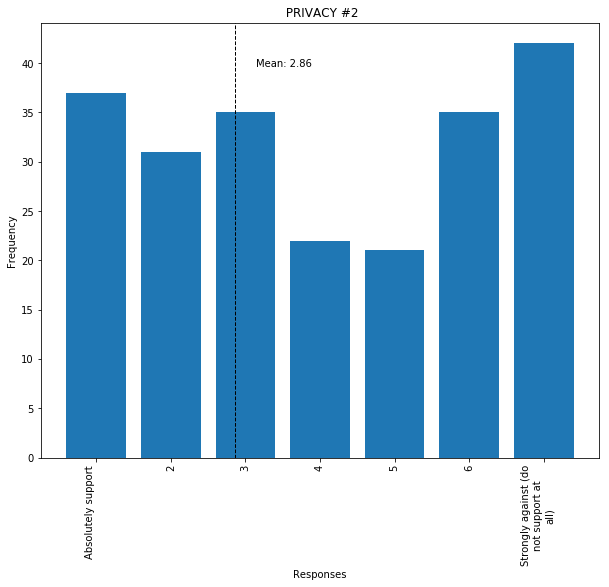

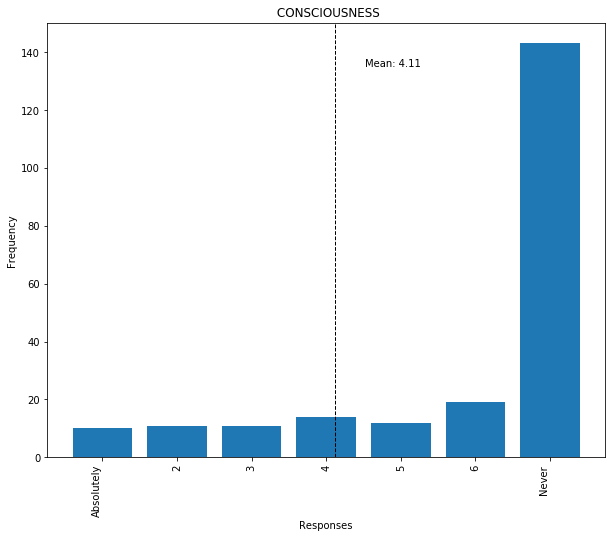

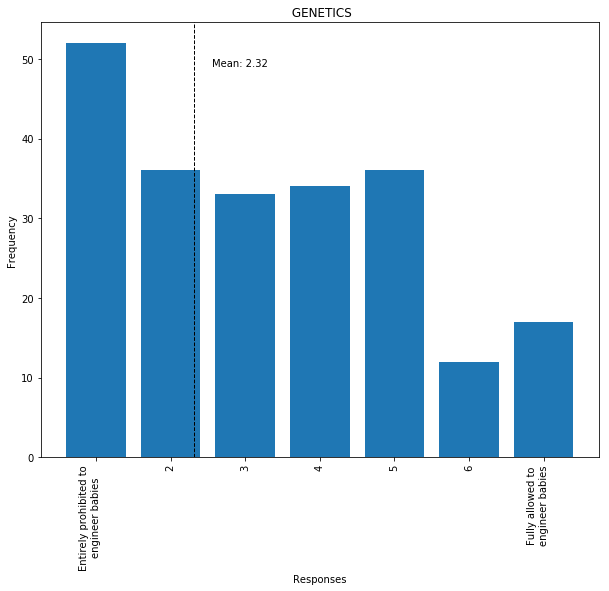

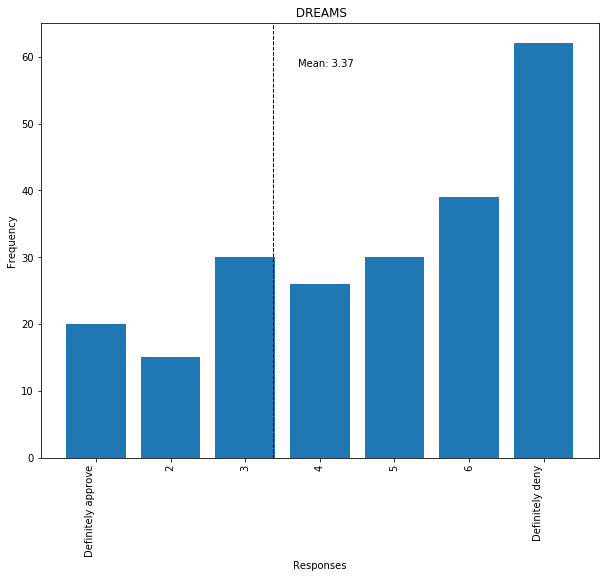

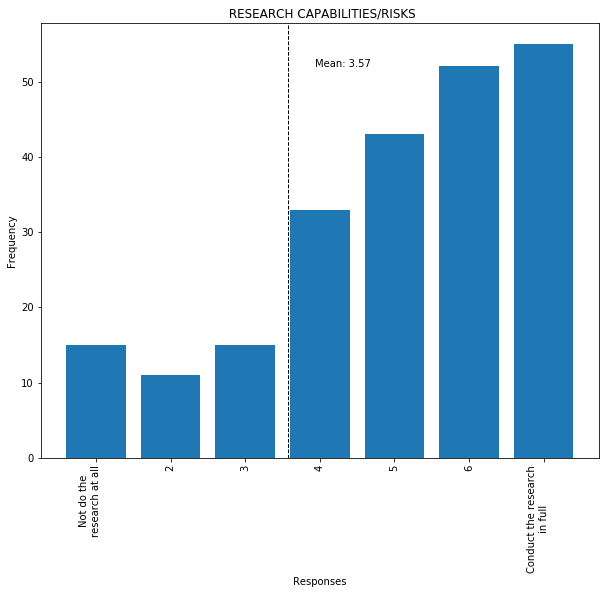

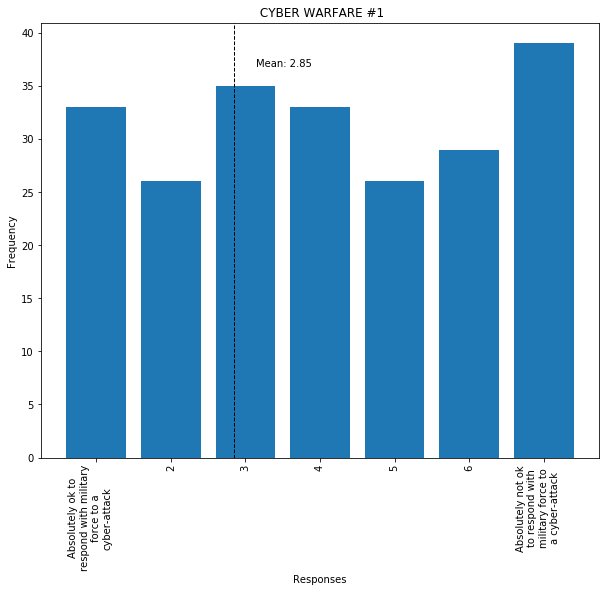

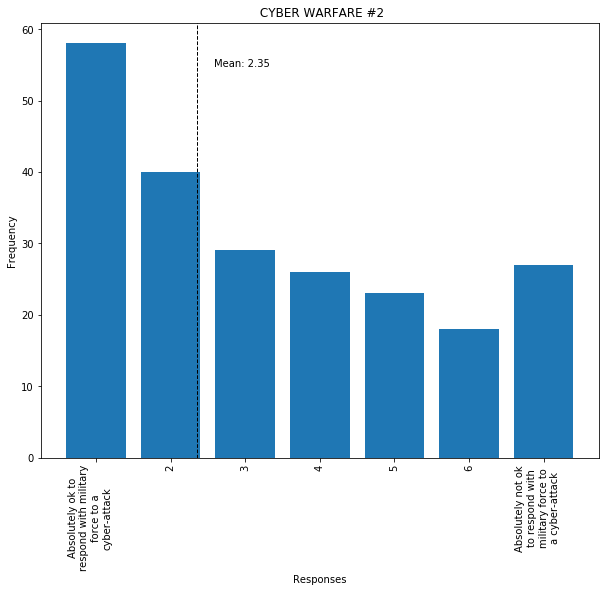

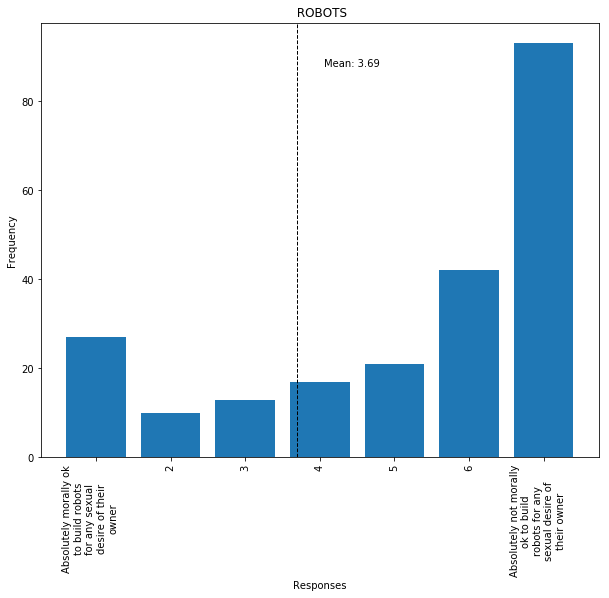

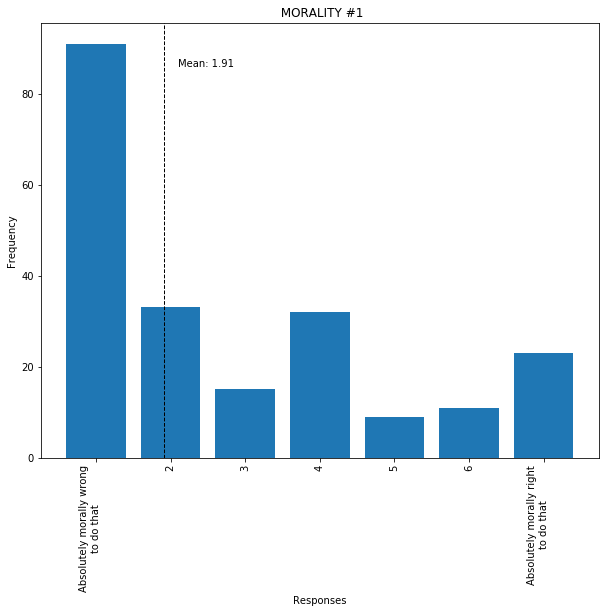

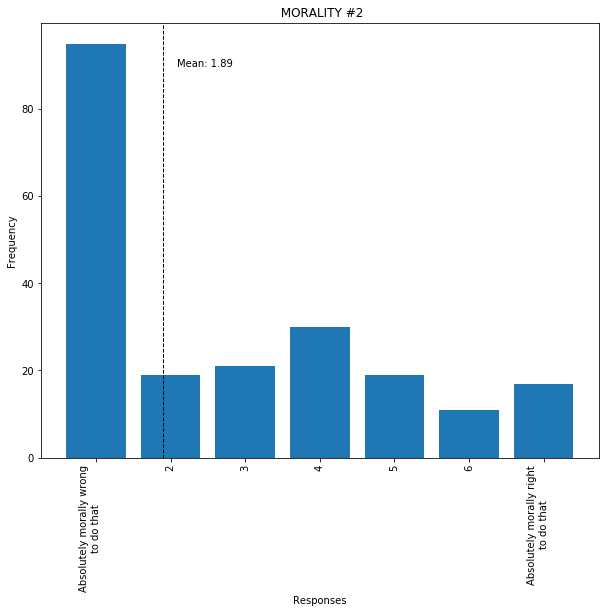

In [47]:

for t in my_keys[0:6]:
    create_histogram(data, t, column_mapping, text_mapping, prob=False, include_non_answers=False, 
                     show_mean=disp_means[t], show_full_title=True)
for t in my_keys[6:len(my_keys)]:
    create_histogram(data, t, column_mapping, text_mapping, prob=False, include_non_answers=False, 
                     show_mean=disp_means[t], show_full_title=False, short_titles=short_question_text)

## Make all of the M v F double-bar histograms

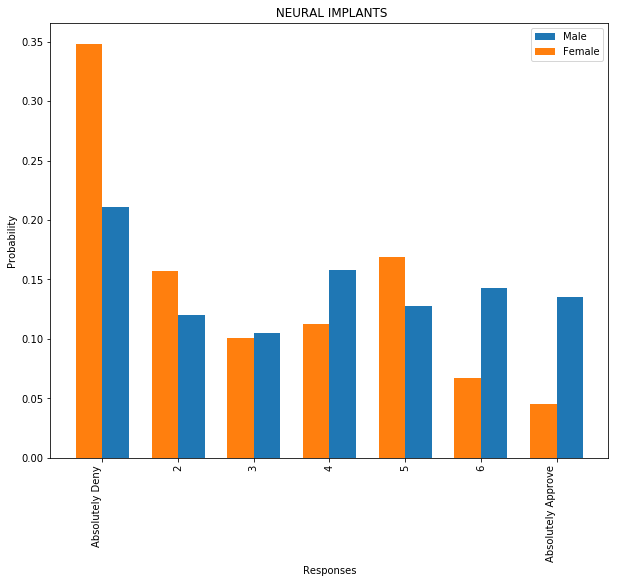

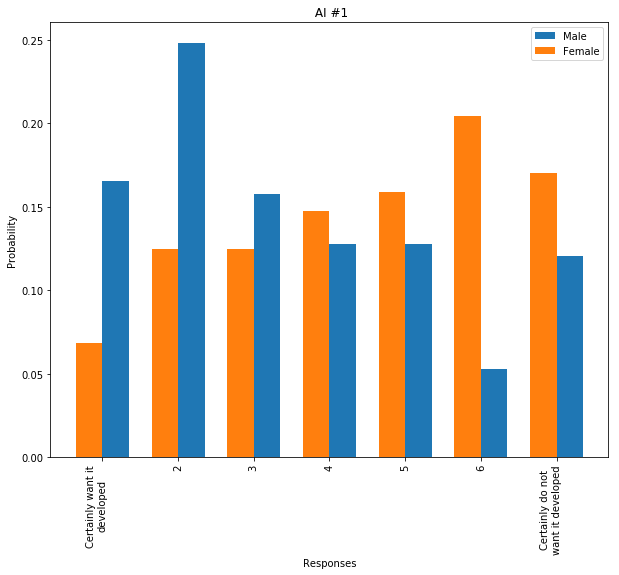

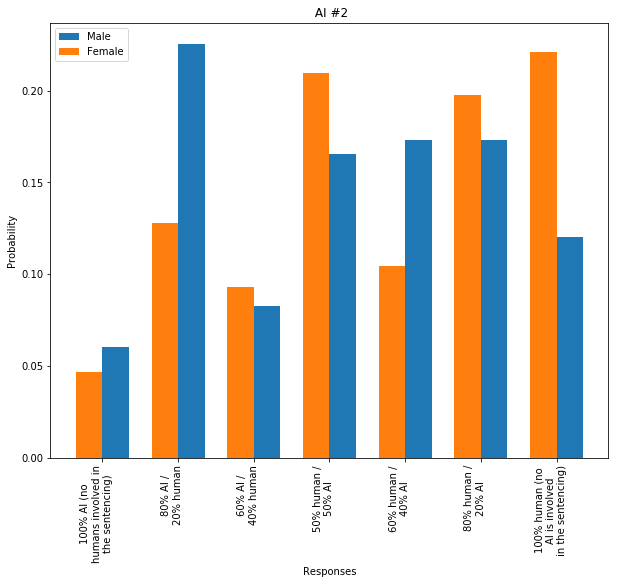

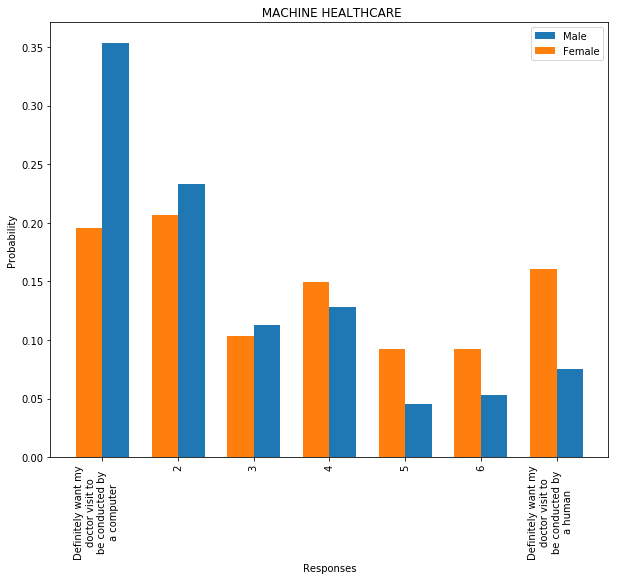

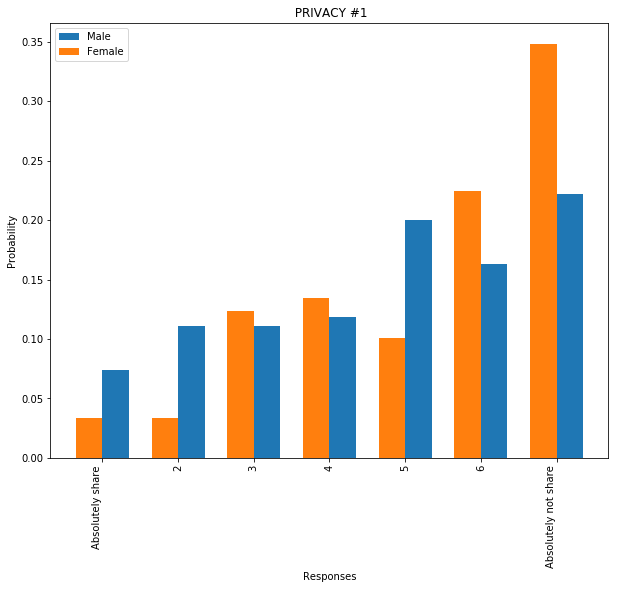

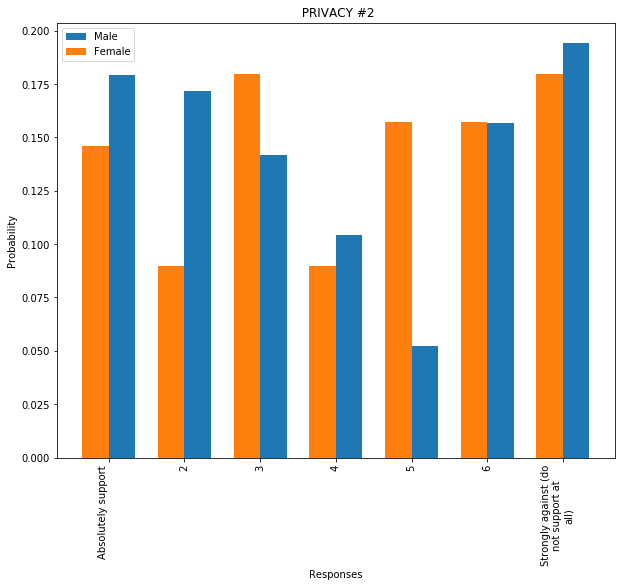

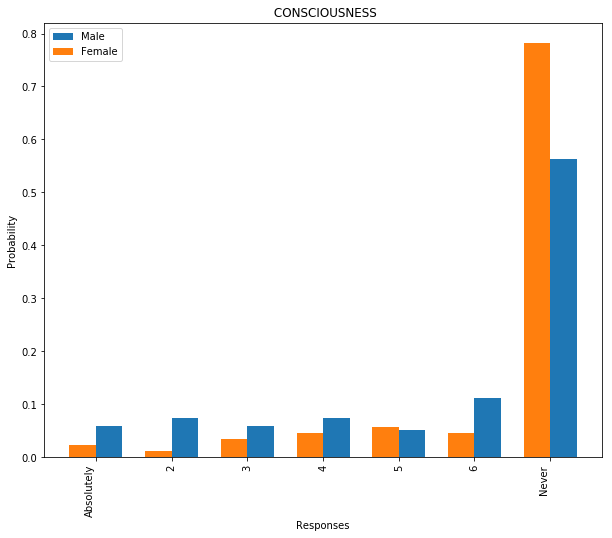

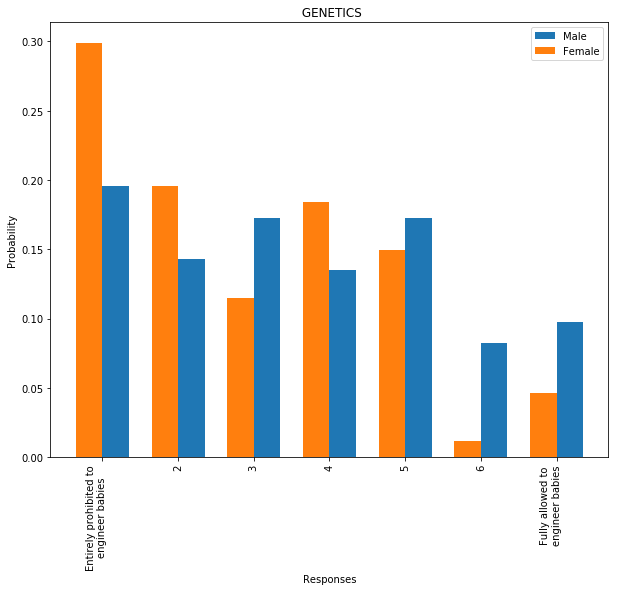

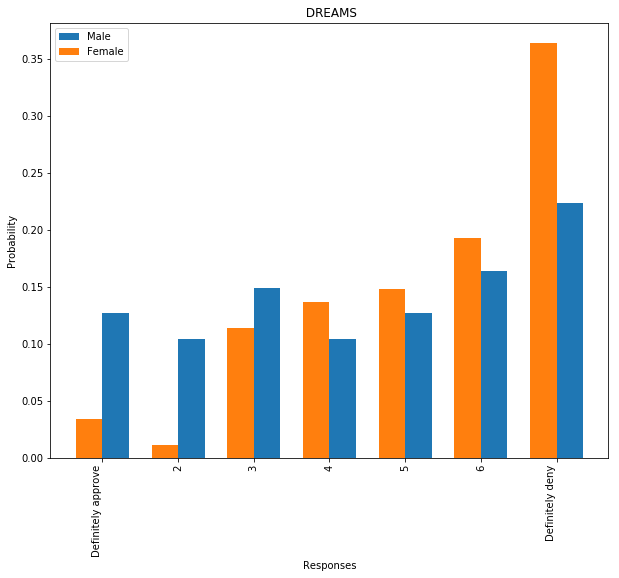

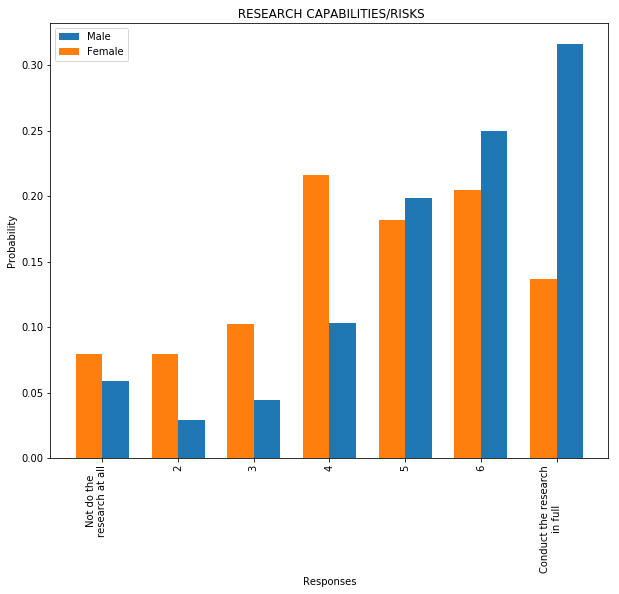

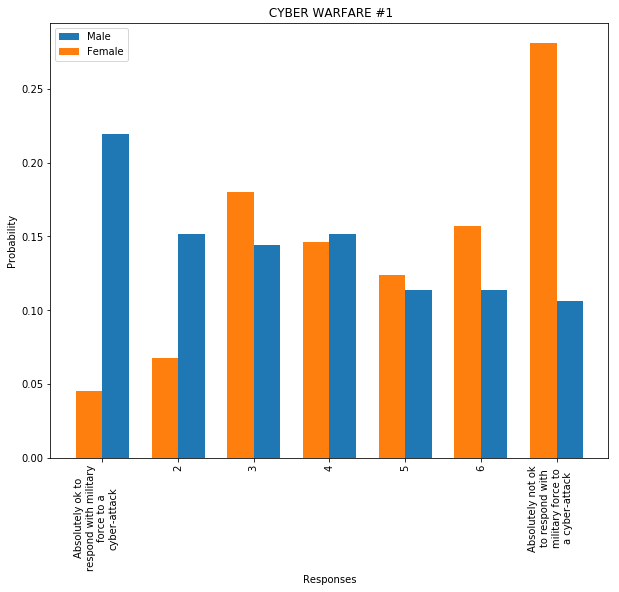

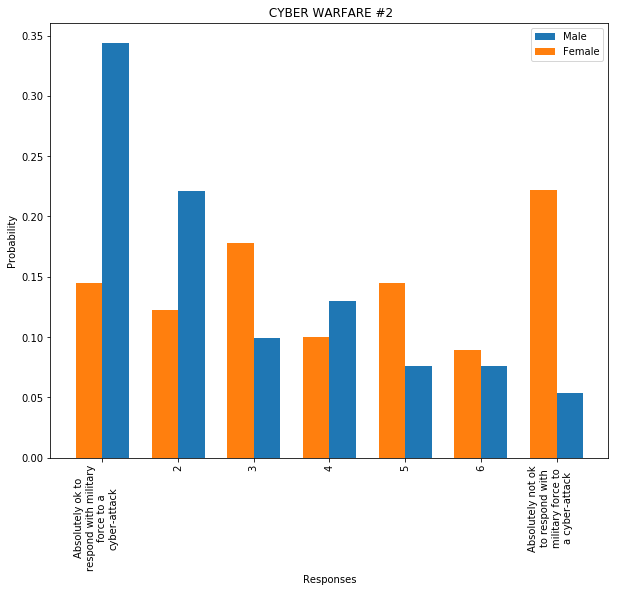

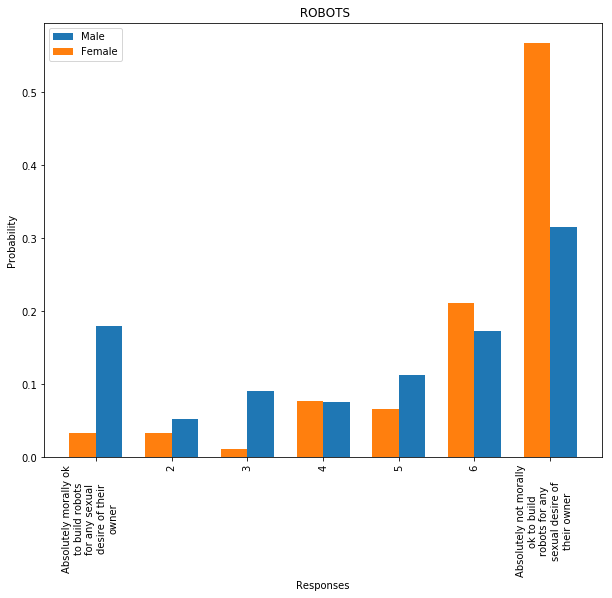

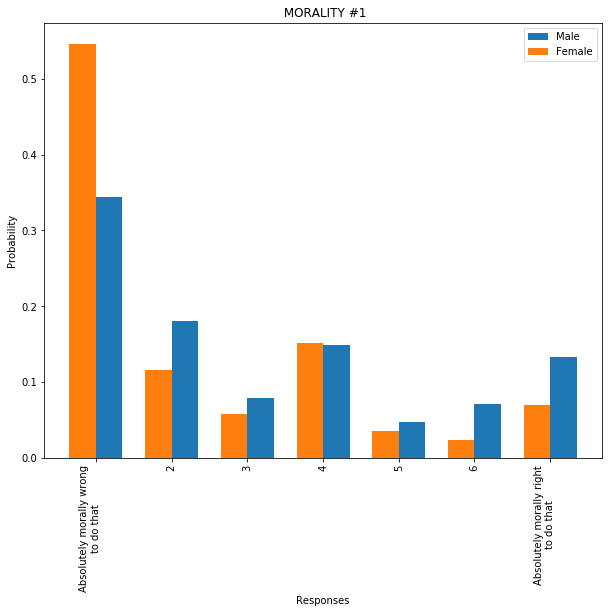

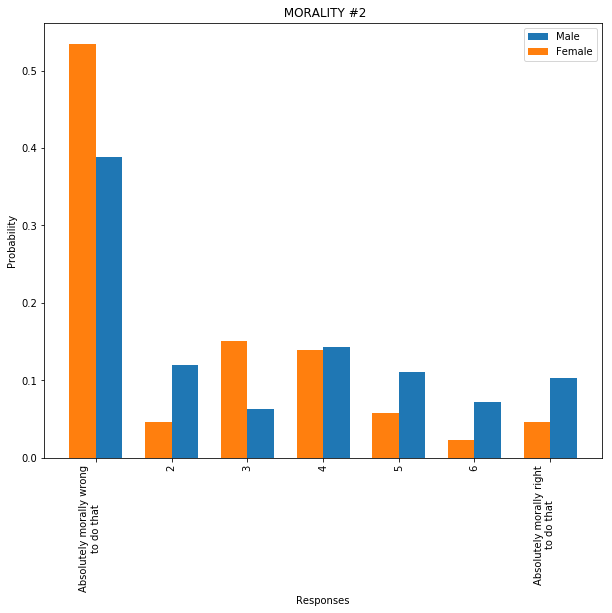

In [48]:
for t in my_keys[6:len(my_keys)]:
    create_multi_histogram(data, 'I02', t, column_mapping, text_mapping, prob=True, include_non_answers=False, 
                           show_mean=False, show_full_title=False, short_titles=short_question_text)

In [50]:
my_keys

['I02',
 'I03',
 'I04',
 'I05',
 'I06',
 'I07',
 'Q01_1',
 'Q02_1',
 'Q03_1',
 'Q04_1',
 'Q05_1',
 'Q06_1',
 'Q07_1',
 'Q08_1',
 'Q09_1',
 'Q10_1',
 'Q11_1',
 'Q12_1',
 'Q13_1',
 'Q14_1',
 'Q15_1']

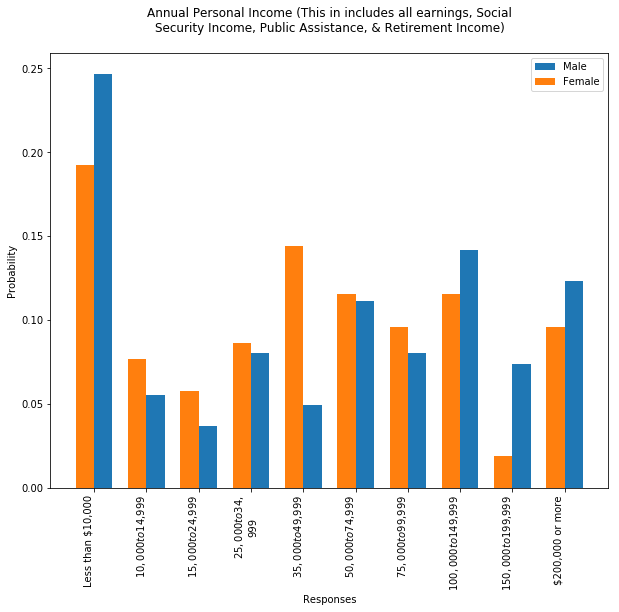

{1.0: [0.24691358024691357,
  0.05555555555555555,
  0.037037037037037035,
  0.08024691358024691,
  0.04938271604938271,
  0.1111111111111111,
  0.08024691358024691,
  0.1419753086419753,
  0.07407407407407407,
  0.12345679012345678],
 2.0: [0.19230769230769232,
  0.07692307692307693,
  0.057692307692307696,
  0.08653846153846154,
  0.14423076923076922,
  0.11538461538461539,
  0.09615384615384616,
  0.11538461538461539,
  0.019230769230769232,
  0.09615384615384616]}

In [61]:
create_multi_histogram(data, 'I02', 'I07', column_mapping, text_mapping, prob=True, include_non_answers=False, 
                           show_mean=False, show_full_title=True, short_titles=short_question_text)

# Debugging code 

In [ ]:
peep = data.groupby(['Q01_1', 'I02'])['I03'].count()

In [ ]:
peep.keys
{1.0: [43, 28, 16, 14, 21, 17, 19], 2.0: [18, 31, 14, 9, 10, 15, 6]}


In [ ]:
print(sum(all_counts[labels_demo[1]]))
print(sum(all_counts[labels_demo[0]]))
print(peep[j][labels_demo[i]])

In [ ]:
print(text_mapping[t_demo][1][labels[2]])


In [ ]:
text_mapping[t_demo][1][labels_demo[i]]

In [ ]:
np.arange(5)

In [ ]:
create_multi_histogram()

In [ ]:
all_counts

In [ ]:
ppp = sum(all_counts[labels_demo[0]])

In [ ]:
lie = [x/ppp for x in all_counts[labels_demo[0]]]

In [ ]:
lie

In [ ]:
sum(lie)

In [ ]:
len(list(data[data['Q01_1'] == labels[3]]['I02']))

In [ ]:
labels_demo

In [ ]:
peep[1][float(1)]

In [ ]:
data.groupby('Q01_1')['I02'].count()

In [ ]:
len(list(data[data['I02'] == float(1)]['Q01_1']))

In [ ]:
type(data[data['I02'] == float(1)]['Q01_1'])

In [ ]:
176+107+32

In [ ]:
len(list(data[data['I02'] == float(2)]['Q01_1']))

In [ ]:
len(list(data[data['I02'] == float(0)]['Q01_1']))

In [ ]:
len(list(data['I02']))

In [ ]:
x1 = list(data[data['I02'] == 1][0])

In [ ]:
question_text

In [ ]:
caps = re.findall('([A-Z]+(?:(?!\s?[A-Z][a-z])\s?[A-Z])+)', question_text['Q03_1'])

In [ ]:
x_axis_labels = generate_x_axis_labels_hist('Q01_1', text_mapping, False)
    #for i in range(0,len(x_axis_labels)):
    #    x_axis_labels[i] = wrap_by_word(x_axis_labels[i], 3)

In [ ]:
x_axis_labels

In [ ]:
for i in range(0,len(x_axis_labels)):
        x_axis_labels[i] = wrap_by_word(x_axis_labels[i], 3)
        if len(x_axis_labels[i]) < 1:
            x_axis_labels[i] = "  "

In [ ]:
x_axis_labels = []

In [ ]:
text_data.loc('I02', '0')

In [ ]:
text_data['I02'][data[data['I02']==1.0].index.values[0]]

In [ ]:
relevant_data = { your_key: old_dict[your_key] for your_key in your_keys }

In [ ]:
tempo = data.columns[1]

In [ ]:
my_keys.remove('I03')

In [ ]:
data_col = pd.DataFrame(data, columns=['I03'])
    
flat_list = [item for sublist in pd.Index.tolist(data_col) for item in sublist]

In [ ]:
len(flat_list)

In [ ]:
stats.binned_statistic(flat_list, flat_list, statistic='count', bins=10)[1][:-1]

In [ ]:
len(list(filter((0.0).__ne__, flat_list)))

In [ ]:
stats.ttest_ind(flat_list_gender, flat_list_income, equal_var=False, nan_policy='omit')

In [ ]:
res = calculate_t_test(data, column_mapping, 'Gender', 'Q01_1')

In [ ]:
res

In [ ]:
r